In [6]:
import pandas as pd
import os
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt

# Classifying X-Ray Images With Statistical Learning
---

This notebook/blog documents our building up of a Pipeline and Disease Classifier for the NIH X-Ray Dataset. Our project consisted of analyzing, cleaning, and modifying said dataset for deep learning training, building and training our own classification models, retuning hyperparameters for better accuracy, and comparing results. One of the unique techniques we tested out was training upon the  `discrete latent space` of the `VQ-VAE` model, [*Neural Discrete Representation Learning* (van den Oord et al, NeurIPS 2017)](https://arxiv.org/abs/1906.00446). the Vector-Quantized Variational AutoEncoder (`VQ-VAE`) is a generative model based on Variational Auto Encoders (`VAE`) which aims to make the latent space discrete using Vector Quantization (`VQ`) techniques. We will be comparing the performance of our "hacky" model with a traditional CNN classifier, and the State-of-the-art [Densenet](https://arxiv.org/abs/1608.06993) classifier. Overall, after extensive tuning and refining of our model with statistical optimizations, we found that our preliminary VQ-VAE model performed on par with the Densenet architecture, which in turn, with further optimizations, can perform as well as, or potentially better than, the average board-certified radiologist.

# Dataset and Hyperparameters
First we will load the dataset. Every image is RGB and 1024x1024 pixel. We'll then clean, process, and augment the data so that it's ready to train on.

In [3]:
## Load the NIH data toa pandas dataframe
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('data','images*', '*', '*.png'))}

print('Total X-Ray images found:', len(all_image_paths))

Total X-Ray images found: 112120


Keeping only Posterior to Anterior (PA) Scans:

In [4]:
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
pa_xray_df = all_xray_df.drop(all_xray_df.loc[all_xray_df['View Position']=='AP'].index)

We will now take the diagnosis label, and embed them into a 0-1 vector for every X-Ray Image:

In [5]:
label_set = pa_xray_df.rename(columns={'Finding Labels': 'labels'})
label_set = label_set.set_index('Image Index').labels.str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('labels')
label_set = pd.get_dummies(label_set, columns=['labels']).groupby(level=0).sum()
label_set.head()

labels_Atelectasis  labels_Cardiomegaly  \
Image Index                                                 
00000001_000.png                   0                    1   
00000001_001.png                   0                    1   
00000001_002.png                   0                    1   
00000002_000.png                   0                    0   
00000003_000.png                   0                    0   

                  labels_Consolidation  labels_Edema  labels_Effusion  \
Image Index                                                             
00000001_000.png                     0             0                0   
00000001_001.png                     0             0                0   
00000001_002.png                     0             0                1   
00000002_000.png                     0             0                0   
00000003_000.png                     0             0                0   

                  labels_Emphysema  labels_Fibrosis  labels_Hernia  \
Image Index                                                          
00000001_000.png                 0                0              0   
00000001_001.png                 1                0              0   
00000001_002.png                 0                0              0   
00000002_000.png                 0                0              0   
00000003_000.png                 0                0              1   

                  labels_Infiltration  labels_Mass  labels_No Finding  \
Image Index                                                             
00000001_000.png                    0            0                  0   
00000001_001.png                    0            0                  0   
00000001_002.png                    0            0                  0   
00000002_000.png                    0            0                  1   
00000003_000.png                    0            0                  0   

                  labels_Nodule  labels_Pleural_Thickening  labels_Pneumonia  \
Image Index                                                                    
00000001_000.png              0                          0                 0   
00000001_001.png              0                          0                 0   
00000001_002.png              0                          0                 0   
00000002_000.png              0                          0                 0   
00000003_000.png              0                          0                 0   

                  labels_Pneumothorax  
Image Index                            
00000001_000.png                    0  
00000001_001.png                    0  
00000001_002.png                    0  
00000002_000.png                    0  
00000003_000.png                    0

Merging the original dataframe with the new `label_set` with the labels:

In [6]:
pa_xray_df.set_index('Image Index', inplace=True)
prepared_df = pa_xray_df.merge(label_set, left_index = True, right_index=True)
prepared_df.head()
prepared_df.to_csv("data/formatted_image_database.csv")

In [8]:
prepared_df = pd.read_csv("data/formatted_image_database.csv", index_col="Image Index")

clean_data, unclean_data = train_test_split(prepared_df, test_size=0.2, random_state=42)

Here we are performing image augmentations on the X-Ray images: Centering, resizing, and reformatting the images so that they can be more readily processed and trained on by our models

In [7]:
train_data_augmented = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False)



In [220]:
labels = ["labels_Emphysema", "labels_Fibrosis", "labels_Hernia", "labels_Infiltration", "labels_Mass", "labels_No Finding", "labels_Nodule", "labels_Pleural_Thickening", "labels_Pneumonia", "labels_Pneumothorax"]

In [123]:
#clean_data["None"] = None
#unclean_data["None"] = None
train_generator = train_data_augmented.flow_from_dataframe(
    unclean_data, x_col='path', y_col=labels, weight_col=None,
    target_size=(1024, 1024), color_mode='rgb', classes=labels,
    class_mode='raw', batch_size = 15, shuffle=True, seed=42,
    save_to_dir=None, save_prefix='', save_format='png', subset=None,
    interpolation='nearest', validate_filenames=True)

Found 13462 validated image filenames.


In [125]:
batch = next(train_generator)

AttributeError: 'tuple' object has no attribute 'shape'

In [110]:
validation_generator = val_datagen.flow_from_dataframe(
    unclean_data, x_col='path', weight_col=None,
    target_size=(1000, 1000), color_mode='rgb', classes=["recons", "None"],
    class_mode='input', batch_size = 15, shuffle=True, seed=42,
    save_to_dir=None, save_prefix='', save_format='png', subset=None,
    interpolation='nearest', validate_filenames=True)

/x-ray-stuff/ai_packages/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


KeyboardInterrupt: 

In [33]:
def generate_data_generator(generator, train_data):
    gen = generator.flow_from_dataframe(
        train_data, x_col='path', weight_col=None,
        target_size=(1024, 1024), color_mode='rgb', classes=["recons", "None"],
        class_mode='input', batch_size = 16, shuffle=True, seed=42,
        save_to_dir=None, save_prefix='', save_format='png', subset=None,
        interpolation='nearest', validate_filenames=True)
    while(True):
        sample = gen.next()
        x = sample[0]
        y = sample[1]
        yield x, [y, None]

We're going to load up our data now. Fair warning that this will take quite a bit of time!

In [23]:
cleaned_data = generate_data_generator(val_datagen, clean_data)
test_data = generate_data_generator(val_datagen, unclean_data)

In [113]:
#train_data = next(train_data)
#print(train_data[1])
print(next(train_generator))


(array([[[[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        

In [11]:
#np.save("train_data1.npy", train_data1)
single_indices = np.argwhere(np.sum(train_data_labels, axis=1) == 1)
single_train_labels = train_data_labels[single_indices][:,0,:]
single_train_data = train_data[single_indices][:,0,:,:,:]

NameError: name 'train_data_labels' is not defined

Now that we've cleaned the data so that we are only focusing on single-condition diagnoses, let's see how many of each diagnosis is found in this new cleaned dataset:

In [ ]:
dicts = {label : 0 for label in labels}
imags = []
corresponding_labels = []


while len(corresponding_labels) < 48:
    imgs, lbels = next(train_generator)
    for i in range(15):
        if sum(lbels[i]) == 1:
            if dicts[labels[list(lbels[i]).index(1)]] < 5:
                dicts[labels[list(lbels[i]).index(1)]] += 1
                imags.append(imgs[i])
                corresponding_labels.append(labels[list(lbels[i]).index(1)])
                
print(corresponding_labels)
imags = np.array(imags)
print(imags.shape)

'''            
# The following code shuffles our fully cleaned data for training purposes
for label in dicts:
    print(label, dicts[label])
indices = np.array(indices)
np.random.shuffle(indices)
train_labels_modified = single_train_labels[indices]
train_data_modified = single_train_data[indices]
print(len(train_labels_modified))
'''

Here is a sample of what some of the images look like:

In [12]:
t_x, t_y = train_data_modified[:4], train_labels_modified[:4]
fig, m_axs = plt.subplots(1, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y[5] == 1: 
        c_ax.set_title('Healthy')
    else:
        c_ax.set_title('Something wrong')
    c_ax.axis('off')

NameError: name 'train_data_modified' is not defined

# Building VQ-VAE Architecture 
the VQ-VAE consists of an encoder, a discrete **codebook** of $K$ latent codes, $\mathcal E = \{e_0 \dots e_{K-1} \}$ where $\forall i, e_i \in \mathbb{R}^d$.

\begin{align}
&\textbf{input }x \tag{W x H x C}\\
z_e &= f(x) \tag{w x h x d}\\
z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
\end{align}

and finally a decoder, that should in theory output a clean reconstruction of the input image.

Below is the forked implementation of the model, with hyperparameters and optimizations adapted for our X-Ray images and current pipeline:

In [59]:
# Hyperparameters
NUM_LATENT_K = 64                  # Number of codebook entries
NUM_LATENT_D = 128                  # Dimension of each codebook entries
BETA = 0.9                         # Weight for the commitment loss

INPUT_SHAPE = (1000,1000,3)          # Spatial size of latent embedding
SIZE = 64                          
                                   
VQVAE_BATCH_SIZE = 128             # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 500             # Number of epochs
VQVAE_LEARNING_RATE = 0.001        # Learning rate
VQVAE_LAYERS = [8, 16, 32, 64, 128]     # Number of filters for each layer in the encoder

In [13]:
# Code forked from https://www.kaggle.com/ameroyer/keras-vq-vae-for-image-generation
# Modified and optimized for our pipeline
class VectorQuantizer(K.layers.Layer):  
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k
    
    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)
        
    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index
    
    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

The decoder then takes the quantized codes as inputs and spits out the output image. Our architecture involves a series of convolutional layers that shrink the image by a factor of 2 every layer, followed by a series of transpose convolutional layers that double the image size every layer:

In [14]:
def encoder_pass(inputs, d, num_layers=[8, 16, 32,64]):
    x = inputs

    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='elu', 
                            kernel_initializer = "he_normal", 
                            strides=(1, 1), name="conv{}".format(i + 1))(x)
        if i != 3:
            x = K.layers.MaxPooling2D()(x)
        x = K.layers.BatchNormalization()(x)
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='elu', 
                            kernel_initializer = "he_normal",
                            strides=(1, 1), name="conv2{}".format(i + 1))(x)
        x = K.layers.BatchNormalization()(x)

    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', kernel_initializer = "he_normal",
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[64,32, 16, 1]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(1, 1), padding="SAME", 
                                     kernel_initializer = "he_normal",
                                     activation='elu', name="convT{}".format(i + 1))(y)
        if i != 3:
            y = K.layers.UpSampling2D()(y)
        y = K.layers.BatchNormalization()(y)
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(1, 1), padding="SAME", 
                                     kernel_initializer = "he_normal",
                                     activation='elu', name="convT2{}".format(i + 1))(y)
        y = K.layers.BatchNormalization()(y)
    decoded = K.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), 
                                       kernel_initializer = "he_normal",
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded

Once these three building blocks are done, we can build the full `VQ-VAE`. As noted previously, code is forked from online Machine Learning practitioners.

In [15]:
def build_vqvae(k, d, input_shape=(1000, 1000, 3), num_layers=[8, 16, 32, 64]):
    global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')
    
    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')
    
    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")
    
    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook
    
    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook


Alongside the standard MSE Loss, which will be our reconstruction loss, we will also define VQ "Latent" to ensure that encoder outputs stay close to codebook entry values, and also keep the size of the codebook dictionary relatively sparse. the loss function, as defined in the paper, is as follows:

\begin{align}
\mathcal L_{\text{VQ-VAE}}(x) = - \mathbb{E}_{z \sim f(x)}{p(x | z)} + \| z_e - \bar{z_q}\|^2 + \|\bar{z_e} - z_q\|^2
\end{align}

where $\bar{\cdot}$ denotes the stop gradient operation. 

KL Divergence loss is used for training of the prior which is unrelated to our classification problem. This will be an issue once we try to generate random samples, however, which will be discussed later.

In [16]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss    



We're also going to monitor the $L2$ [norms](https://mathworld.wolfram.com/VectorNorm.html) of the encoded vectors, both the sample vector, and encoder output vector.

In [17]:
def zq_norm(y_true, y_pred):
    del y_true
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))

def ze_norm(y_true, y_pred):
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #check gpu status
early_stop = K.callbacks.EarlyStopping(verbose=1, patience=1, mode='min',  restore_best_weights=True)

Num GPUs Available:  2


In [211]:
class Sampling(K.layers.Layer):
    def call(self, inputs):
        mean, logvar = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        return mean + tf.exp(0.5 * logvar) * tf.random.normal(mean = 0, stddev = 1, shape = (batch, dim))

def create_encoder(in_shape, filters):
    input_enc = K.layers.Input(in_shape, name = 'encoder_inputs')
    x = input_enc
    for i in filters:
        x = K.layers.Conv2D(i,
                            kernel_initializer = 'he_normal',
                            strides = (1, 1),
                            padding = 'same',
                            kernel_size = (5, 5),
                            activation = 'elu')(x)
        x = K.layers.MaxPooling2D()(x)
        x = K.layers.BatchNormalization()(x)
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(100, kernel_initializer = 'he_normal', activation = 'elu')(x)
    x = K.layers.BatchNormalization()(x)
    mean = K.layers.Dense(1, kernel_initializer = 'he_normal', activation = 'elu')(x)
    logvar = K.layers.Dense(1, kernel_initializer = 'he_normal', activation = 'elu')(x)
    sample = Sampling()([mean, logvar])
    return K.Model(inputs = input_enc, outputs = [mean, logvar, sample])
    
def create_decoder(filters):
    input_dec = K.layers.Input(shape = (1,))
    x = K.layers.Dense(100)(input_dec)
    x = K.layers.Dense(32 * 32 * 8, kernel_initializer = 'he_normal', activation = 'elu')(x)
    x = K.layers.Reshape((32, 32, 8))(x)
    for i in filters:
        x = K.layers.Conv2DTranspose(i,
                              kernel_initializer = 'he_normal',
                              strides = (1, 1),
                              padding = 'same',
                              kernel_size = 3,
                              activation = 'elu')(x)
        x = K.layers.UpSampling2D()(x)
        x = K.layers.BatchNormalization()(x)
    out = K.layers.Conv2DTranspose(3, 
                                 kernel_size = 3, 
                                 kernel_initializer = 'he_normal', 
                                 strides = (1, 1), 
                                 activation = 'sigmoid',
                                 padding = 'same')(x)
    return K.Model(inputs = input_dec, outputs = out)

In [216]:
class BetaVAE(K.Model):
    def __init__(self, im_shape, filters, beta, **kwargs):
        super(BetaVAE, self).__init__(**kwargs)
        self.encoder = create_encoder(im_shape, filters)
        self.decoder = create_decoder(filters)
        self.beta = beta
        self.kl_div_tracker = K.metrics.Mean(name = 'kl_loss')
        self.recon_loss_tracker = K.metrics.Mean(name = 'recon_loss')
        self.total_loss_tracker = K.metrics.Mean(name = 'total_loss')
        
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.recon_loss_tracker,
                self.kl_div_tracker]
    
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            mean, logvar, sample = self.encoder(inputs)
            recon = self.decoder(sample)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    K.losses.binary_crossentropy(inputs, recon),
                    axis = (1, 2)
                )
            )
            kl_loss = 0.5 * (tf.exp(logvar) + tf.square(mean) - 1 - logvar)
            total_loss = recon_loss + self.beta * kl_loss
        gradients = tape.gradients(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.kl_div_tracker.update_state(kl_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss" : self.total_loss_tracker.result(),
            "recon_loss" : self.recon_loss_tracker.result(),
            "kl_loss" : self.kl_div_tracker.result()}

In [218]:
bvae = BetaVAE(im_shape = (1024, 1024, 3), filters = [8, 16, 32, 64, 100, 128], beta = 0.9)
bvae.compile(optimizer = K.optimizers.Adam(), loss = None)
bvae.fit(batch, epochs = 1)

ValueError: The model cannot be compiled because it has no loss to optimize.

In [21]:
densenet = tf.keras.applications.DenseNet121(weights = 'imagenet',
                                             include_top=False, pooling = 'avg',
                                             input_shape=[224, 224, 3])
densenet.trainable = True
dense_model = tf.keras.Sequential([
    densenet,
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = "lecun_normal")
])
dense_model.compile(loss="categorical_crossentropy", metrics = ["accuracy"], optimizer = K.optimizers.Adam(1e-3))
dense_model.summary()
history_dense = dense_model.fit(train_data_modified, y = train_labels_modified, validation_split = 0.2, callbacks=[early_stop], epochs = 100)

29089792/29084464 [==============================] - 0s 0us/step


KeyboardInterrupt: 

In [26]:
#mirrored_strategy = tf.distribute.MirroredStrategy()
#with mirrored_strategy.scope():
vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(1e-4, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False))
vq_vae.summary()
vq_vae.load_weights("FINAL_TRAINED_VQ_super_v2.h5")

Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 1000, 1000,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1000, 1000, 8 224         encoder_inputs[0][0]             
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 500, 500, 8)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 500, 500, 8)  32          max_pooling2d_8[0][0]            
_____________________________________________________________________________________________

In [51]:
vq_vae2, vq_vae_sampler2, encoder2, decoder2, codes_sampler2, get_vq_vae_codebook2 = build_vqvae(NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae2.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(1e-4, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False))
vq_vae2.summary()

Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1024, 1024, 8 224         encoder_inputs[0][0]             
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 512, 512, 8)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 512, 512, 8)  32          max_pooling2d_26[0][0]           
_____________________________________________________________________________________________

In [18]:
#vq_vae.load_weights("FINAL_TRAINED_VQ_super.h5")
history_vq = vq_vae.fit_generator(train_generator, validation_data= validation_generator, steps_per_epoch=3000, epochs=500, verbose=2)
vq_vae.save_weights("FINAL_TRAINED_VQ_super.h5")
'''
Current Stats after 69 Epochs:
loss: 0.0054 - decoder_loss: 0.0023 - latent_codes_loss: 0.0032
latent_codes_zq_norm: 0.1514 - latent_codes_ze_norm: 0.1544
val_loss: 0.0056 - val_decoder_loss: 0.0023 - val_latent_codes_loss: 0.0032
val_latent_codes_zq_norm: 0.1503 - val_latent_codes_ze_norm: 0.1518
'''

NameError: name 'vq_vae' is not defined

In [55]:
history_vq2 = vq_vae2.fit_generator(generate_data_generator(train_data_augmented, clean_data),
                                  validation_data = generate_data_generator(val_datagen, unclean_data),
                                  steps_per_epoch=3330, epochs=3, 
                                  callbacks = [early_stop], 
                                  validation_steps = 840, 
                                  verbose=2)
vq_vae2.save_weights("FINAL_TRAINED_VQ_small_latent.h5")

Epoch 1/3
Found 53848 validated image filenames.
Epoch 1/3
Found 13462 validated image filenames.
3330/3330 - 14888s - loss: 0.0039 - decoder_loss: 0.0017 - latent_codes_loss: 0.0022 - latent_codes_zq_norm: 0.0699 - latent_codes_ze_norm: 0.0746 - val_loss: 0.0035 - val_decoder_loss: 0.0017 - val_latent_codes_loss: 0.0018 - val_latent_codes_zq_norm: 0.0695 - val_latent_codes_ze_norm: 0.0703
Epoch 2/3
Epoch 1/3
3330/3330 - 15141s - loss: 0.0029 - decoder_loss: 0.0013 - latent_codes_loss: 0.0016 - latent_codes_zq_norm: 0.0703 - latent_codes_ze_norm: 0.0736 - val_loss: 0.0025 - val_decoder_loss: 0.0012 - val_latent_codes_loss: 0.0013 - val_latent_codes_zq_norm: 0.0735 - val_latent_codes_ze_norm: 0.0768
Epoch 3/3
Epoch 1/3
Restoring model weights from the end of the best epoch.
3330/3330 - 14921s - loss: 0.0026 - decoder_loss: 0.0011 - latent_codes_loss: 0.0015 - latent_codes_zq_norm: 0.0733 - latent_codes_ze_norm: 0.0763 - val_loss: 0.0031 - val_decoder_loss: 0.0011 - val_latent_codes_loss

Now that our VQ-VAE model is trained, let's look at the loss charts to see when or if overfitting occurred.

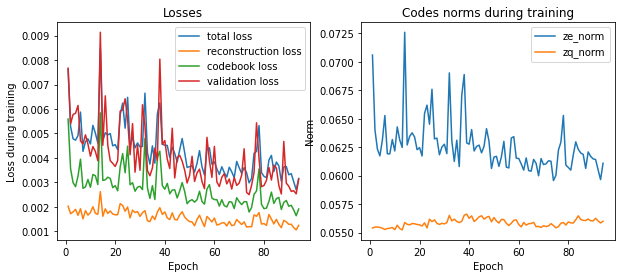

In [28]:
num_epochs = range(1, len(history_vq.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history_vq.history["loss"], label="total loss")
plt.plot(num_epochs, history_vq.history["decoder_loss"], label="reconstruction loss")
plt.plot(num_epochs, history_vq.history["latent_codes_loss"], label="codebook loss")
plt.plot(num_epochs, history_vq.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history_vq.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history_vq.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

Let's check out what some of the reconstructions look like from this VQ-VAE. Note that since this is an X-Ray image, we are most likely not able to get perfect reconstructions, but instead we should look for promising results.

Left: Original, Right: Generated reconstruction


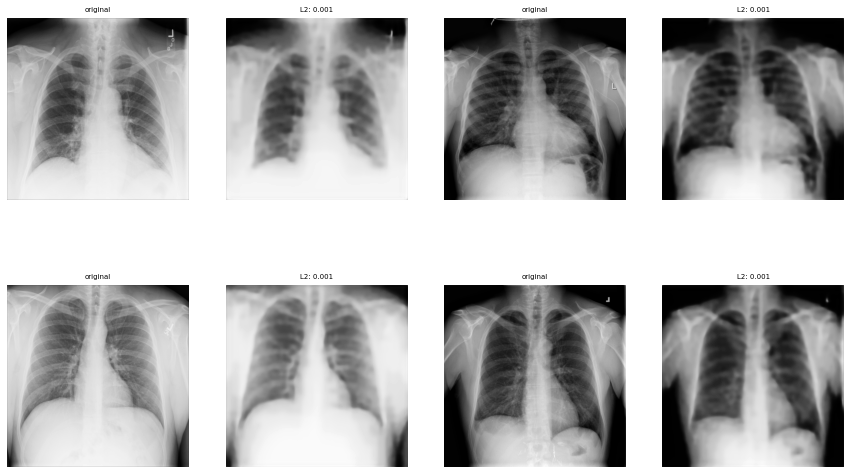

In [58]:
def reconstruction(model, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    recons, code = model.predict(x)
    dists = np.mean((recons - x)**2, axis=(1, 2, 3))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i, :, :, 1], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i, :, :, 2], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Left: Original, Right: Generated reconstruction")
#images = next(cleaned_data)
#images2 = generate_data_generator(val_datagen, unclean_data)
reconstruction(vq_vae2, next(images2)[0:4][0], 2, 2, random = False)

These reconstructions are actually quite decent! Now, our hypothesis is that the latent space representation might have "learned" some information about the images that's valuable for diagnosing the conditions. Let's see whether or not this is true:

(150, 4096)
(150, 50)
[[ -97.66693505 -302.67290347  -60.4158601  ...   11.67328393
    -6.09787073  -65.27852456]
 [  41.49608182 -359.84131334 -107.51647193 ...  -67.19467657
   -27.59200226   -2.74317526]
 [  91.57969538 -342.46764616  120.16656296 ...  -22.8123346
   -62.747528     74.06322116]
 ...
 [ 130.96839291 -264.12617051   96.21031443 ...   59.8271805
   -24.23977032  -86.86618082]
 [ 325.03153023  188.00776591 -240.93930833 ...   39.25586019
  -103.97544557  -72.16623621]
 [  82.30430868 -299.60979772  -61.32330284 ...   69.60440279
    38.85146334  -20.7085457 ]]


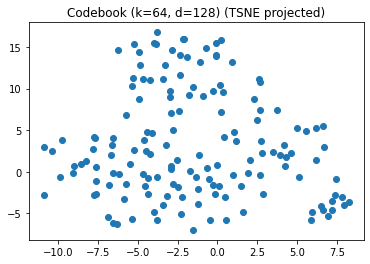

In [109]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#print(next(images2))

#codebooks = []
#for i in range(150):
#    codebooks.append(encoder2.predict(next(images2)[0:3])[0].reshape(1, -1))
#codebooks = np.array(codebooks)
codebooks = np.reshape(codebooks, (150,4096))
print(codebooks.shape)

pca = PCA(n_components = 50, svd_solver = 'randomized')
codebook = pca.fit_transform(codebooks)
print(codebook.shape)
print(codebook)

codebook = TSNE(2).fit_transform(codebook)
plt.title("Codebook (k={}, d={}) (TSNE projected)".format(NUM_LATENT_K, NUM_LATENT_D))
plt.scatter(codebook[:, 0], codebook[:, 1], )
plt.axis('on')
plt.show()

In [62]:
#vq_vae.load_weights("FINAL_TRAINED_VQ.h5")
latent = encoder.predict(train_data_modified)
classifier = K.Sequential([K.layers.Input(shape = latent.shape[1:]),
                           K.layers.Flatten(),
                           K.layers.BatchNormalization(),
                           K.layers.Dense(128, activation = 'selu', kernel_initializer = 'lecun_normal'),
                           K.layers.BatchNormalization(),
                           K.layers.Dense(64, activation = 'selu', kernel_initializer = 'lecun_normal'),
                           K.layers.BatchNormalization(),
                           K.layers.Dense(10, activation = "softmax", kernel_initializer = 'glorot_normal')])

classifier.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = K.optimizers.Adam(1e-3))
classifier.summary()
history_vq_class = classifier.fit(latent, y = train_labels_modified, callbacks=[early_stop], epochs = 100)

NameError: name 'train_data_modified' is not defined

Here is a simple classifier for single images from our test data:

In [906]:
def make_prediction(encoder, classifier, image):
    global labels
    image = np.expand_dims(image, axis = 0)
    latent = encoder.predict(image)
    output = classifier.predict(latent)
    label = labels[np.argmax(output)]
    return "This X-Ray diagnosis: " + label[7:]

make_prediction(encoder, classifier, train_data_modified[1000])

'This X-Ray diagnosis: Infiltration'

Finally, we have 3 trained models, and have measured and saved their performances. Let's plot the graphs to see how well each of them did!

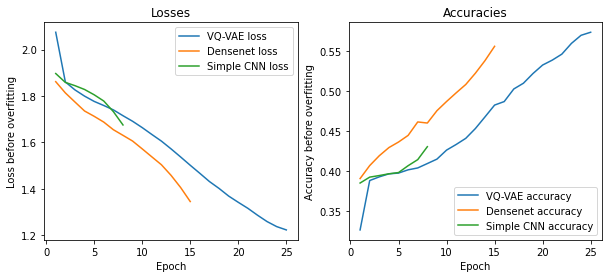

In [886]:
loss_base = history_base.history["loss"]
acc_base = history_base.history["acc"]
base_best = np.argmin(history_base.history["val_loss"])[-1]

loss_dense = history_dense.history["loss"]
acc_dense = history_dense.history["acc"]
dense_best = np.argmin(history_dense.history["val_loss"])[-1]

loss_vq = history_vq_class.history["loss"]
acc_vq = history_vq_class.history["acc"]
vq_best = np.argmin(history_vq_class.history["val_loss"])[-1]


num_epochs = range(1, 37)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 26), loss_vq[:25], label="VQ-VAE loss")
plt.plot(np.arange(1,16), history_dense.history['loss'][:15], label="Densenet loss")
plt.plot(np.arange(1,9), history_base.history['loss'][:8], label="Simple CNN loss")

plt.xlabel("Epoch")
plt.ylabel("Loss before overfitting")
plt.legend()
plt.title("Losses")

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 26), acc_vq[:25], label="VQ-VAE accuracy")
plt.plot(np.arange(1,16), history_dense.history['acc'][:15], label="Densenet accuracy")
plt.plot(np.arange(1,9), history_base.history['acc'][:8], label="Simple CNN accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy before overfitting")
plt.title("Accuracies")
plt.legend()
#plt.show()

As one can see, the simple CNN fares the worst, whereas the VQ-VAE and the Densenet Architecture classifications are on par with each other, which is quite exciting for our findings. While the accuracy ratings top out at around 60% for each on our multiclass classification tests, we believe that with further hyperparameter tuning and layer reshaping, our models can perform up to par with board-certified radiologists, and possibly surpass them.

# X-Ray Generation
Another stretch goal of ours we had was to use the VQ-VAE as a generator for new X-Ray images. As the architecture currently stands, images generated from a random sample from the latent space are highly unlikely to be resemblant of actual X-Ray images due to the prior being assumed as a uniform, or sometimes basic Gaussian N(0,1) distribution. The following images are then generated from sampling from said distributions:

Images generated under a uniform prior:


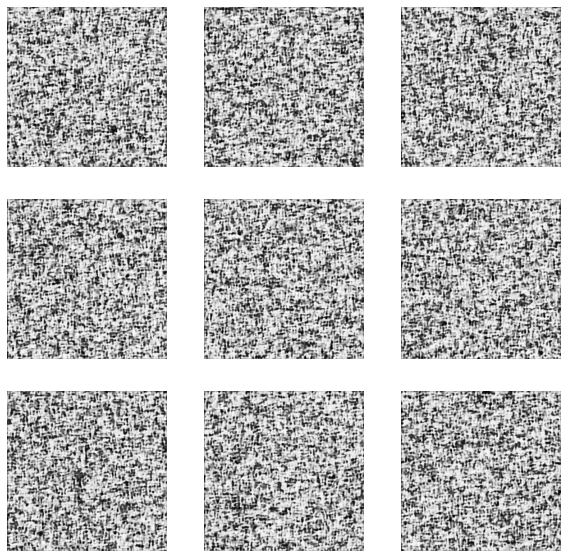

In [50]:
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 48    # Width of each PixelCNN block

def generate_from_random(sampler, k, size, n_row, n_col):
    n = n_col * n_row
    indices = np.random.randint(0, k, size=(n, size, size))
    generated = sampler.predict(indices, steps=1)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Images generated under a uniform prior:")
generate_from_random(vq_vae_sampler, NUM_LATENT_K, SIZE, 3, 3)

As noted in the VQ-VAE2 paper, we decided to make use of the PixelSnail CNN architecture to train on the latent space in order to generate more realistic "random" latent representations, which would in turn be converted into an entirely new X-Ray image (with a diagnosis from our classifier model) via our trained VQ-VAE decoder. Below is the code for the CNN Architecture, courtesy of some amazing ML practitioners online:

In [58]:
# Referencing https://www.kaggle.com/ameroyer/keras-vq-vae-for-image-generation

def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)
        
    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)
    
    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)
    
    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out


def accuracy(y_true, y_pred):
    size = int(y_pred.get_shape()[-2])
    k = int(y_pred.get_shape()[-1])
    y_true = tf.reshape(y_true, (-1, size * size))
    y_pred = tf.reshape(y_pred, (-1, size * size, k))
    return Kb.cast(Kb.equal(y_true, Kb.cast(Kb.argmax(y_pred, axis=-1), Kb.floatx())), Kb.floatx())


# Now to build the PixelCNN:

def build_pixelcnn(codes_sampler, k, size, num_layers, num_feature_maps=32):
    pixelcnn_prior_inputs = K.layers.Input(shape=(size, size), name='pixelcnn_prior_inputs', dtype=tf.int32)
    z_q = codes_sampler(pixelcnn_prior_inputs) # maps indices to the actual codebook
    
    v_stack_in, h_stack_in = z_q, z_q
    for i in range(num_layers):
        mask = 'b' if i > 0 else 'a'
        kernel_size = 3 if i > 0 else 7
        residual = True if i > 0 else False
        v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, num_feature_maps,
                                                     kernel=kernel_size, residual=residual, i=i + 1)

    fc1 = K.layers.Conv2D(filters=num_feature_maps, kernel_size=1, name="fc1")(h_stack_in)
    fc2 = K.layers.Conv2D(filters=k, kernel_size=1, name="fc2")(fc1) 
    # outputs logits for probabilities of codebook indices for each cell

    pixelcnn_prior = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')

    # Distribution to sample from the pixelcnn
    dist = tf.distributions.Categorical(logits=fc2)
    sampled = dist.sample()
    prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')
    return pixelcnn_prior, prior_sampler

pixelcnn_prior, prior_sampler = build_pixelcnn(codes_sampler, NUM_LATENT_K, SIZE, 
                                               PIXELCNN_NUM_BLOCKS, PIXELCNN_NUM_FEATURE_MAPS)
pixelcnn_prior.summary()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
Model: "pixelcnn-prior"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pixelcnn_prior_inputs (InputLay [(None, 125, 125)]   0                                            
__________________________________________________________________________________________________
codes_sampler (Model)           (None, 125, 

In order to get a better understanding of our latent space, here's a way to visualize the discrete codes representation as a mapping to a color:

Images encoded as discrete codes
Found 13462 validated image filenames.
Discrete latent space as an array: 
 [[36 36 41 ... 28 28 28]
 [41 41 24 ... 16 12 24]
 [30 28 59 ... 16 16 12]
 ...
 [36 58 36 ... 36 58 36]
 [36 58 36 ... 36 58 36]
 [55 55 41 ... 55 55 30]]


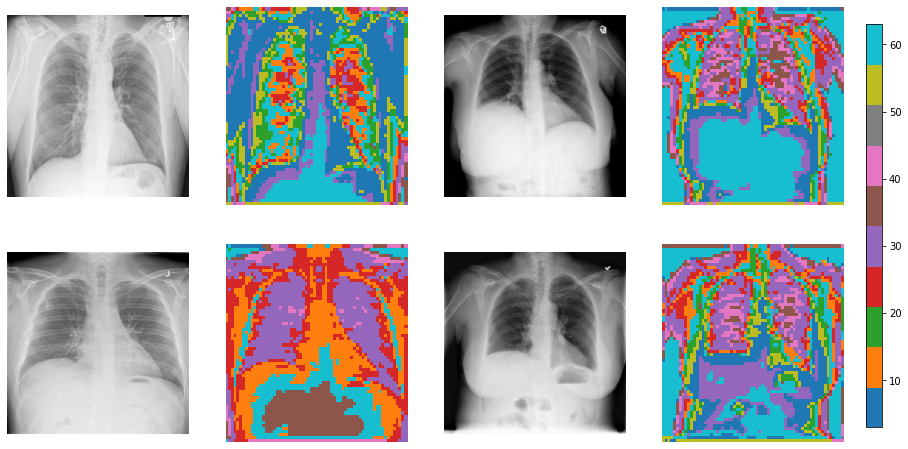

In [42]:
def viz_codes(encoder, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    codes = encoder.predict(x)
    print("Discrete latent space as an array: \r\n", codes[0])
    fig = plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2*i+1)
        plt.imshow(x[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2*i+2)
        plt.pcolor(codes[i, ::-1, :], cmap='tab10') #flip y-axis origin to match imshow
        plt.axis('off')
    cbaxes = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    cb = plt.colorbar(cax=cbaxes)  
    plt.show()
    
#print("Discrete latent space as an array: \r\n", latent[0])
print("Images encoded as discrete codes")
viz_codes(encoder2, next(generate_data_generator(val_datagen, unclean_data))[:10][0], 2, 2)

Now to train our CNN to develop new latent samples:

In [59]:
def generate_latent_generator(encoder, generator, train_data):
    gen = generator.flow_from_dataframe(
        train_data, x_col='path', weight_col=None,
        target_size=(1000, 1000), color_mode='rgb', classes=["recons", "None"],
        class_mode='input', batch_size = 16, shuffle=True, seed=42,
        save_to_dir=None, save_prefix='', save_format='png', subset=None,
        interpolation='nearest', validate_filenames=True)
    while(True):
        sample = gen.next()
        x = encoder.predict(sample[0])
        yield x, x

In [77]:
latent = generate_latent_generator(encoder, val_datagen, clean_data)
val_latent = generate_latent_generator(encoder, val_datagen, unclean_data)
print(next(latent))

StopIteration: 

In [73]:
pixelcnn_prior.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[accuracy],
                       optimizer=K.optimizers.Adam(PIXELCNN_LEARNING_RATE))
config = tf.ConfigProto(
    device_count={'GPU': 1},
    intra_op_parallelism_threads=1,
    allow_soft_placement=True
)

session = tf.Session(config=config)
K.backend.set_session(session)
with session.as_default():
    with session.graph.as_default():
        prior_history = pixelcnn_prior.fit_generator(generate_latent_generator(encoder, val_datagen, clean_data), validation_data=generate_latent_generator(encoder, val_datagen, unclean_data), callbacks=[early_stop], steps_per_epoch = 3330, epochs=10, validation_steps=840, verbose=1)

Epoch 1/10
Found 53848 validated image filenames.


InvalidArgumentError: Tensor encoder_inputs:0, specified in either feed_devices or fetch_devices was not found in the Graph

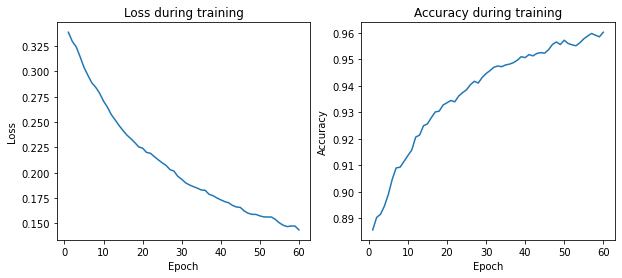

In [842]:
num_epochs = range(1, len(prior_history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, prior_history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, prior_history.history["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.show()

Once again, we can check the model ability to **reconstruct** discrete latent codes obtained from the test set:

Originals versus reconstructions


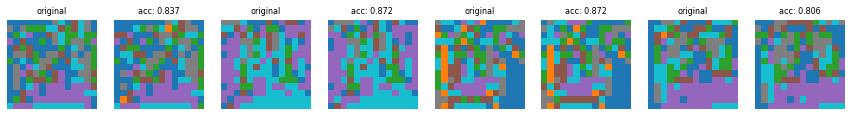

In [829]:
def recons_prior(model, z, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(z.shape[0], size=n, replace=False)
        x = z[x]
    else:
        x = z[:n]
    recons = model.predict(x)
    recons = np.argmax(recons, axis=-1)
    accs = np.mean(np.equal(recons, x), axis=(1, 2))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i], cmap='tab10')
        plt.title("original", fontsize=8)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i], cmap='tab10')
        plt.title("acc: {:.3f}".format(accs[i]), fontsize=8)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
z_test = encoder.predict(latent[1000:1100])
recons_prior(pixelcnn_prior, z_test, 1, 4)

Now when we sample from this new "prior" PixelCNN and run it through the VQ-VAE decoder, we get completely new X-Ray images!

Random codes sampled from the prior and corresponding decoded images


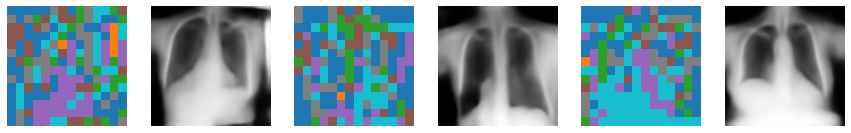

In [841]:
def sample_from_prior(prior, shape):
    """sample from the PixelCNN prior, pixel by pixel"""
    global prior_sampler
    X = np.zeros(shape, dtype=np.int32)
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            sampled = prior_sampler.predict(X)
            X[:, i, j] = sampled[:, i, j]
    return X
            
    
def generate(prior, codes_sampler, size, n_row, n_col):
    """Generate random images by sampling codes from the given prior"""
    n = n_col * n_row
    indices = sample_from_prior(prior, (n, size, size))
    zq = codes_sampler(indices)
    generated = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(indices[i], cmap='tab10')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Random codes sampled from the prior and corresponding decoded images")
generate(prior_sampler, codes_sampler, 14, 1, 3)